In [2]:
# pylint: disable-all
import cv2
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from keras.models import load_model

In [3]:
import tensorflow as tf
print(tf.__version__)

# List all physical devices
physical_devices = tf.config.list_physical_devices('GPU')

# Check if any GPUs are available
if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices}")
else:
    print("TensorFlow is not using any GPU.")

2.11.0
TensorFlow is using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-13 11:26:43.188019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-13 11:26:43.191607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-13 11:26:43.191684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(
        layer_name).output).predict(img_array)

    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0, :, :, k])
                            for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(
            -np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(
            -np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:, :, :, max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0, :, :, k], input_shape[:2],
                                       interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / \
                (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0, :, :, k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:, cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0, :, :, :], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0

    return cam


def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)
    return f

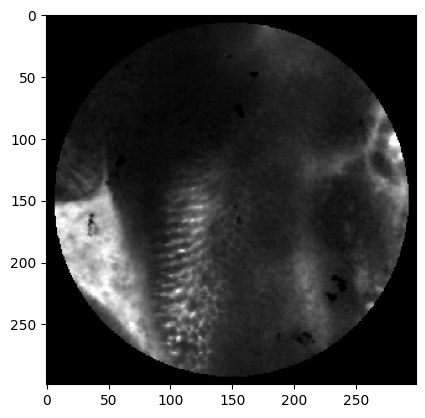

In [5]:
img1 = '/home/abidhasan/Documents/Indicate_FH/grad_cam_images/original_0.png'
orig_img = np.array(load_img(
    img1), dtype=np.uint8)
plt.imshow(orig_img)
plt.show()

In [6]:
from gradcamutils import read_and_preprocess_img
import matplotlib.pyplot as plt
model_name = 'vgg16'
img_array, layer_name = read_and_preprocess_img(img1, model_name)

This script ran successfully


In [7]:
import tensorflow.python.platform.build_info as build
print(build.build_info['cuda_version'])
print(build.build_info['cudnn_version'])

11.2
8


In [8]:
model = load_model(
    '/home/abidhasan/Documents/Indicate_FH/saved_model/vgg16_100.h5')

2024-06-13 11:27:27.431143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-13 11:27:27.431309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-13 11:27:27.431408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-13 11:27:27.701463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-13 11:27:27.701574: I tensorflow/compiler/xla/stream_executo

/home/abidhasan/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-06-13 11:27:35.309052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-06-13 11:27:36.054853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


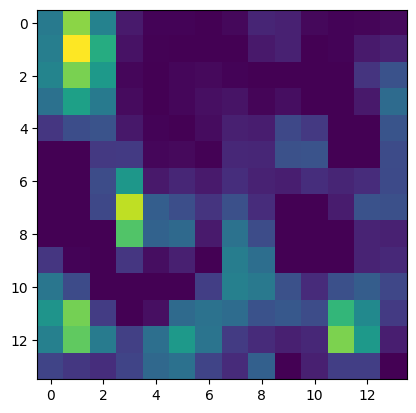

In [9]:
score_cam = ScoreCam(model, img_array, layer_name)

plt.imshow(score_cam)
plt.show()